## Importing libraries

In [1]:
# Input and Output from Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Stage 1 - ANN

## Get the data

In [17]:
# Generate input - output data

def generate_xt(num_samples=10):
    x = np.random.uniform(-100, 100, num_samples) # Input random
    # x = np.random.randint(-100, 100, num_samples) # Input random
    t = np.zeros(num_samples)
    
    t[0] = 0   # Inisialisasi
    
    for k in range(1, num_samples):
        t[k] = 1 / (1 + t[k-1]**2) + 0.25*x[k] - 0.3*x[k-1]
    
    df = pd.DataFrame({"x": x, "t": t})
    return df

df = generate_xt(30002)
print(df)

               x          t
0     -49.643541   0.000000
1      -0.550299  15.755488
2     -39.824338  -9.786983
3     -43.031901   1.199658
4     -92.622611  -9.836108
...          ...        ...
29997  84.735209  -2.999637
29998  -0.769312 -25.512869
29999  73.189257  18.529642
30000  90.153179   0.584422
30001 -35.076612 -35.069699

[30002 rows x 2 columns]


In [18]:
# Generate dataset from input output
df_lagged = pd.DataFrame({
    "x(t)"   : df["x"],
    "x(t-1)" : df["x"].shift(1),
    "x(t-2)" : df["x"].shift(2),
    "t(t-1)" : df["t"].shift(1),
    "t(t-2)" : df["t"].shift(2),
    "t(t)"   : df["t"]   # target
})  # 3 lagged inputs and 2 lagged outputs

df_lagged = df_lagged.dropna().reset_index(drop=True) # drop NaN values from first lagged rows

# Check the dataset
print(df_lagged.head())
print(df_lagged.shape)

        x(t)     x(t-1)     x(t-2)     t(t-1)     t(t-2)       t(t)
0 -39.824338  -0.550299 -49.643541  15.755488   0.000000  -9.786983
1 -43.031901 -39.824338  -0.550299  -9.786983  15.755488   1.199658
2 -92.622611 -43.031901 -39.824338   1.199658  -9.786983  -9.836108
3  21.912867 -92.622611 -43.031901  -9.836108   1.199658  33.275230
4   0.535805  21.912867 -92.622611  33.275230  -9.836108  -6.439007
(30000, 6)


In [19]:
# dataset
X = df_lagged[["x(t)", "x(t-1)", "x(t-2)", "t(t-1)", "t(t-2)"]].values   # input size=6
T = df_lagged[["t(t)"]].values    # target

# check size of dataset
print(X.shape, T.shape)

(30000, 5) (30000, 1)


## Splitting the dataset

In [20]:
def split_dataset_seq(X, T):
    """
    Membagi dataset 30.000 sample secara berurutan:
    - Train: 15.000 pertama
    - Val: 5.000 terakhir dari train + 5.000 setelah train
    - Test: 10.000 terakhir
    """
    assert len(X) == len(T), "Jumlah X dan T harus sama"
    assert len(X) == 30000, "Dataset harus 30.000 sample sesuai aturan"

    # Train 15.000 pertama
    X_train = X[:15000]
    T_train = T[:15000]

    # Validation = 5000 terakhir train + 5000 setelah train
    X_val = np.concatenate([X[10000:15000], X[15000:20000]])
    T_val = np.concatenate([T[10000:15000], T[15000:20000]])

    # Test = 10000 terakhir
    X_test = X[20000:30000]
    T_test = T[20000:30000]

    return X_train, T_train, X_val, T_val, X_test, T_test

X_train, T_train, X_val, T_val, X_test, T_test = split_dataset_seq(X, T)
print("Train:", X_train.shape, T_train.shape)
print("Val  :", X_val.shape, T_val.shape)
print("Test :", X_test.shape, T_test.shape)


Train: (15000, 5) (15000, 1)
Val  : (10000, 5) (10000, 1)
Test : (10000, 5) (10000, 1)


In [6]:
def normalize2(X_train, X_test=None, X_val=None):
    min_train = X_train.min(axis=0)     # minimum value for each feature
    max_train = X_train.max(axis=0)     # maximum value for each feature
    X_train_norm = 2  * (X_train - min_train) / (max_train - min_train) - 1
    
    X_val_norm = None
    if X_val is not None:
        X_val_norm = 2 * (X_val - min_train) / (max_train - min_train) - 1 if X_val is not None else None
    
    X_test_norm = None
    if X_test is not None:
        X_test_norm = 2 * (X_test - min_train) / (max_train - min_train) - 1 if X_test is not None else None
    
    return X_train_norm, X_val_norm, X_test_norm

def rescale(T_norm, T_train):
    min_train = T_train.min(axis=0)
    max_train = T_train.max(axis=0)
    # inverse of normalize2
    Y_orig = 0.5 * (T_norm + 1) * (max_train - min_train) + min_train
    return Y_orig

# if using bipolar sigmoid activation, use scale [-1, 1]
X_train_norm, X_val_norm, X_test_norm = normalize2(X_train, X_test=X_test, X_val=X_val)
T_train_norm, T_val_norm, T_test_norm = normalize2(T_train, X_test=T_test, X_val=T_val)

print(X_train_norm)

[[ 0.82478309  0.95941282  0.58419174  0.46775262 -0.74394983]
 [ 0.07692954  0.82478309  0.95941282 -0.30331647  0.46775262]
 [ 0.70078646  0.07692954  0.82478309 -0.01380069 -0.30331647]
 ...
 [-0.93376822  0.13474653 -0.02260289  0.01041135  0.14275745]
 [-0.67800063 -0.93376822  0.13474653 -0.2647926   0.01041135]
 [-0.21811966 -0.67800063 -0.93376822  0.34879193 -0.2647926 ]]


## Neural Network Model

In [30]:
class NN:
    def __init__(self, input_size, hidden_size, output_size, lr=0.001, seed=42):
        np.random.seed(seed)

        # Parameters
        self.NI = input_size
        self.NH = hidden_size
        self.NO = output_size
        self.lr = lr

        # Weights
        self.v = np.random.rand(self.NI, self.NH)   # input x hidden
        self.vb = np.random.rand(self.NH)           # 1 x hidden
        self.w = np.random.rand(self.NH, self.NO)   # hidden x output
        self.wb = np.random.rand(self.NO)           # 1 x output

    # --- Set Weights ---
    def set_weights(self, weights):
        """Load weights from dict into the model"""
        self.v = weights["v"].copy()
        self.vb = weights["vb"].copy()
        self.w = weights["w"].copy()
        self.wb = weights["wb"].copy()

    # --- Get Weights ---
    def get_weights(self):
        """Return current weights as a dict"""
        return {
            "v": self.v.copy(),
            "vb": self.vb.copy(),
            "w": self.w.copy(),
            "wb": self.wb.copy()
        }
    
    # --- Activation functions ---
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        s = self.sigmoid(x)
        return s * (1 - s)
    
    # Tanh Activation Function
    def tanh(self, x):
        return np.tanh(x)

    # Derivative of Tanh
    def tanh_derivative(self, x):
        return 1 - np.tanh(x) ** 2

    # --- Feedforward ---
    def feedforward(self, x):
        # hidden units
        self.z_in = np.dot(x, self.v) + self.vb
        self.z = self.sigmoid(self.z_in)                # change activation function here

        # output units
        self.y_in = np.dot(self.z, self.w) + self.wb
        #self.y = self.sigmoid(self.y_in)                # change activation function here! self.y is object in this class
        self.y = self.y_in                                                   

        return self.y

    # --- Backpropagation ---
    def backpropagation(self, x, t):
        # error output
        # delta_y = (t - self.y)*self.sigmoid_derivative(self.y_in)  # change activation function here
        delta_y = (t - self.y)                                   
        # del_w = self.lr * np.outer(self.z, delta_y)
        del_w = np.zeros_like(self.w)
        for k in range(self.NH):
            for j in range(self.NO):
                del_w[k][j] = self.lr * delta_y[j] * self.z[k]
        del_wb = self.lr * delta_y

        # error hidden
        delta_zin = np.dot(delta_y, self.w.T)
        delta_z = delta_zin * self.sigmoid_derivative(self.z_in)  # change activation function here
        # del_v = self.lr * np.outer(x, delta_z)
        del_v = np.zeros_like(self.v)
        for i in range(self.NI):
            for j in range(self.NH):
                del_v[i][j] = self.lr * delta_z[j] * x[i]
        del_vb = self.lr * delta_z

        # update bobot
        self.w += del_w
        self.wb += del_wb
        self.v += del_v
        self.vb += del_vb

        return np.mean(delta_y**2)   # return MSE

    # --- Training loop with validation for BPNN---
    def fit_bpnn(self, X_train, T_train, X_val=None, T_val=None,
            epochs=1000, tol=0.001, patience=20):
        history = {"train_loss": [], "val_loss": []}
        best_val_loss = float("inf")
        best_weights = None
        patience_ctr = 0             

        for epoch in range(epochs):
            mse = 0
            # training
            for i in range(len(X_train)):
                x = X_train[i]
                t = T_train[i]
                self.feedforward(x)
                mse += self.backpropagation(x, t)
            mse /= len(X_train)
            history["train_loss"].append(mse)       # mse for every epoch

            # validation
            if X_val is not None and T_val is not None:
                val_loss = 0
                for i in range(len(X_val)):
                    x = X_val[i]
                    t = T_val[i]
                    y = self.feedforward(x)
                    val_loss += np.mean((t - y)**2)
                val_loss /= len(X_val)
                history["val_loss"].append(val_loss)

                # early stopping check
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_weights = (self.v.copy(), self.vb.copy(), self.w.copy(), self.wb.copy())
                    patience_ctr = 0  # reset patience counter
                else:
                    patience_ctr += 1
                
                # stop training if no improvement for 'patience' epochs
                if patience_ctr >= patience:
                    print(f"Early stopping at epoch {epoch+1}, val_loss={val_loss:.6f}, train_loss={mse:.6f}")
                    if best_weights is not None:
                        self.v, self.vb, self.w, self.wb = best_weights
                    break

            # tolerance check (on training loss)
            if mse < tol:
                print(f"Training stopped at epoch {epoch+1}, train_loss={mse:.6f}")
                if best_weights is not None:
                    self.v, self.vb, self.w, self.wb = best_weights
                break

            if (epoch+1) % 10 == 0 or epoch == 0:
                if val_loss is not None:
                    print(f"Epoch {epoch+1}: train_loss={mse:.6f}, val_loss={val_loss:.6f}")
                else:
                    print(f"Epoch {epoch+1}: train_loss={mse:.6f}")

        return history
    
    # --- Training loop with validation for NARX---
    def fit_narx(self, X_train, T_train, X_val=None, T_val=None,
            epochs=1000, tol=0.001, patience=20, y_lags=2):
        history = {"train_loss": [], "val_loss": []}
        best_val_loss = float("inf")
        best_weights = None
        patience_ctr = 0             # ini untuk apa??

        for epoch in range(epochs):
            mse = 0
            # buffer awal for y-lag
            y_buffer = [np.zeros(self.NO) for _ in range(y_lags)]
            # training
            for i in range(len(X_train)):
                x_only = X_train[i]
                x = np.concatenate([x_only] + y_buffer)  # [x(t), y(t-1), y(t-2)]
                t = T_train[i]
                self.feedforward(x)
                mse += self.backpropagation(x, t)
                # update buffer
                y_buffer = [self.y] + y_buffer[:-1]
            mse /= len(X_train)
            history["train_loss"].append(mse)       # mse for every epoch

            # validation (no weight update)
            if X_val is not None and T_val is not None:
                val_loss = 0
                y_buffer_val = [np.zeros(self.NO) for _ in range(y_lags)]
                for i in range(len(X_val)):
                    x_only = X_val[i]
                    x = np.concatenate([x_only] + y_buffer_val)
                    t = T_val[i]
                    y = self.feedforward(x)
                    val_loss += np.mean((t - y)**2)
                    y_buffer_val = [y] + y_buffer_val[:-1]
                val_loss /= len(X_val)
                history["val_loss"].append(val_loss)

                # early stopping check
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_weights = (self.v.copy(), self.vb.copy(), self.w.copy(), self.wb.copy())
                    patience_ctr = 0  # reset patience counter
                else:
                    patience_ctr += 1
                
                # stop training if no improvement for 'patience' epochs
                if patience_ctr >= patience:
                    print(f"Early stopping at epoch {epoch+1}, val_loss={val_loss:.6f}, train_loss={mse:.6f}")
                    if best_weights is not None:
                        self.v, self.vb, self.w, self.wb = best_weights
                    break

            # tolerance check (on training loss)
            if mse < tol:
                print(f"Training stopped at epoch {epoch+1}, train_loss={mse:.6f}")
                if best_weights is not None:
                    self.v, self.vb, self.w, self.wb = best_weights
                break

            if (epoch+1) % 10 == 0 or epoch == 0:
                if val_loss is not None:
                    print(f"Epoch {epoch+1}: train_loss={mse:.6f}, val_loss={val_loss:.6f}")
                else:
                    print(f"Epoch {epoch+1}: train_loss={mse:.6f}")

        return history
    
    # --- Prediction ---
    def predict(self, X_test):
        outputs = []
        for x in X_test:
            outputs.append(self.feedforward(x))
        return np.array(outputs)
    
    # --- Prediction for NARX---
    def predict_narx(self, X_test, y_lags=2):
        outputs = []
        y_buffer = [np.zeros(self.NO) for _ in range(y_lags)]
        for x_only in X_test:
            x = np.concatenate([x_only] + y_buffer)
            y = self.feedforward(x)
            outputs.append(y)
            y_buffer = [y] + y_buffer[:-1]
        return np.array(outputs)


## Training and Validation

In [31]:
# create model
model = NN(input_size=X_train_norm.shape[1], hidden_size=20, output_size=1, lr=0.01)

# training
history = model.fit_bpnn(X_train_norm, T_train_norm, X_val_norm, T_val_norm, epochs=1000, tol=1e-5, patience=5)

print("Last train loss:", history["train_loss"][-1])
print("Last val loss  :", history["val_loss"][-1])

# saving weights from previous training
weights = model.get_weights()

Epoch 1: train_loss=0.033682, val_loss=0.011519
Epoch 10: train_loss=0.011975, val_loss=0.011211
Epoch 20: train_loss=0.011894, val_loss=0.011122


KeyboardInterrupt: 

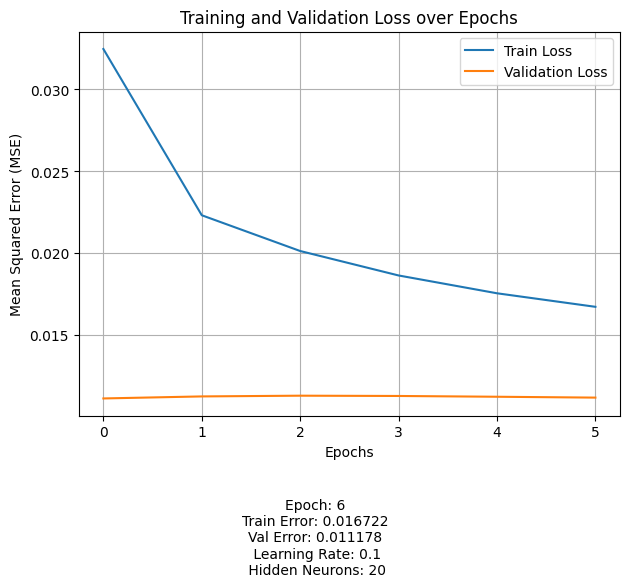

In [29]:
# training validation loss plot
# get the data
train_losses = history["train_loss"]
val_losses = history["val_loss"]

last_epoch = len(train_losses)
train_error = train_losses[-1]
val_error = val_losses[-1]
annotation_text = f"Epoch: {last_epoch}\nTrain Error: {train_error:.6f}\nVal Error: {val_error:.6f}\n Learning Rate: {model.lr}\n Hidden Neurons: {model.NH}"

# plotting
fig, ax = plt.subplots()
ax.plot(train_losses, label='Train Loss')
ax.plot(val_losses, label='Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Mean Squared Error (MSE)')
ax.set_title('Training and Validation Loss over Epochs')
ax.grid(True)
ax.legend()
fig.text(0.5, -0.05, annotation_text, ha='center', va='top')

plt.tight_layout()
plt.show()

# Stage 2

## Getting the Data

In [14]:
# Generate dataset from input output
df_lagged = pd.DataFrame({
    "x(t)"   : df["x"],
    "x(t-1)" : df["x"].shift(1),
    "x(t-2)" : df["x"].shift(2),
    "t(t)"   : df["t"]   # target
})  # 3 lagged inputs and 2 lagged outputs

df_lagged = df_lagged.dropna().reset_index(drop=True) # drop NaN values from first lagged rows

# Check the dataset
print(df_lagged.head())
print(df_lagged.shape)

       x(t)    x(t-1)    x(t-2)      t(t)
0  0.824766  0.959371  0.584217  0.387132
1  0.077046  0.824766  0.959371  0.641495
2  0.700791  0.077046  0.824766  0.860543
3 -0.362085  0.700791  0.077046  0.273778
4  0.092680 -0.362085  0.700791  1.062067
(30000, 4)


## Splitting the dataset

In [15]:
# dataset
X = df_lagged[["x(t)", "x(t-1)", "x(t-2)"]].values   # 100 sampel, input size=6
T = df_lagged[["t(t)"]].values    # target

# check size of dataset
print(X.shape, T.shape)

X_train, T_train, X_val, T_val, X_test, T_test = split_dataset_seq(X, T)
print("Train:", X_train.shape, T_train.shape)
print("Val  :", X_val.shape, T_val.shape)
print("Test :", X_test.shape, T_test.shape)

(30000, 3) (30000, 1)
Train: (15000, 3) (15000, 1)
Val  : (10000, 3) (10000, 1)
Test : (10000, 3) (10000, 1)


In [16]:
# if using bipolar sigmoid activation, use scale [-1, 1]
X_train_norm, X_val_norm, X_test_norm = normalize2(X_train, X_test=X_test, X_val=X_val)
T_train_norm, T_val_norm, T_test_norm = normalize2(T_train, X_test=T_test, X_val=T_val)

## Training and validation

In [17]:
# buat model
y_lags = 2          # lags for feedback
model = NN(input_size=X_train.shape[1]+y_lags, hidden_size=128, output_size=1, lr=0.001)
model.set_weights(weights)

# training
history = model.fit_narx(X_train, T_train, X_val, T_val, epochs=1000, tol=1e-3, patience=20, y_lags=y_lags)

print("Last train loss:", history["train_loss"][-1])
print("Last val loss  :", history["val_loss"][-1])

Epoch 1: train_loss=0.001218, val_loss=0.001133
Epoch 10: train_loss=0.001012, val_loss=0.000957
Training stopped at epoch 11, train_loss=0.000996
Last train loss: 0.0009958729810262007
Last val loss  : 0.0009433357364825234


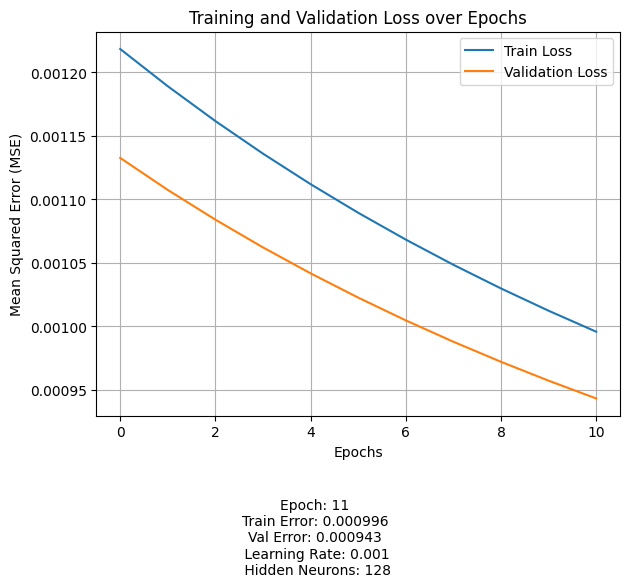

In [18]:
# training validation loss plot
# get the data
train_losses = history["train_loss"]
val_losses = history["val_loss"]

last_epoch = len(train_losses)
train_error = train_losses[-1]
val_error = val_losses[-1]
annotation_text = f"Epoch: {last_epoch}\nTrain Error: {train_error:.6f}\nVal Error: {val_error:.6f}\n Learning Rate: {model.lr}\n Hidden Neurons: {model.NH}"

# plotting
fig, ax = plt.subplots()
ax.plot(train_losses, label='Train Loss')
ax.plot(val_losses, label='Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Mean Squared Error (MSE)')
ax.set_title('Training and Validation Loss over Epochs')
ax.grid(True)
ax.legend()
fig.text(0.5, -0.05, annotation_text, ha='center', va='top')

plt.tight_layout()
plt.show()

In [19]:
# testing
predictions = model.predict_narx(X_test, y_lags = y_lags)
mse_test = np.mean((T_test - predictions)**2)

print("Predictions:", predictions.flatten())
print("Test MSE:", mse_test)

Predictions: [ 1.0968987  -0.13911897  1.39867395 ...  0.88895143  0.84254777
  0.66964565]
Test MSE: 0.0009595635477675739


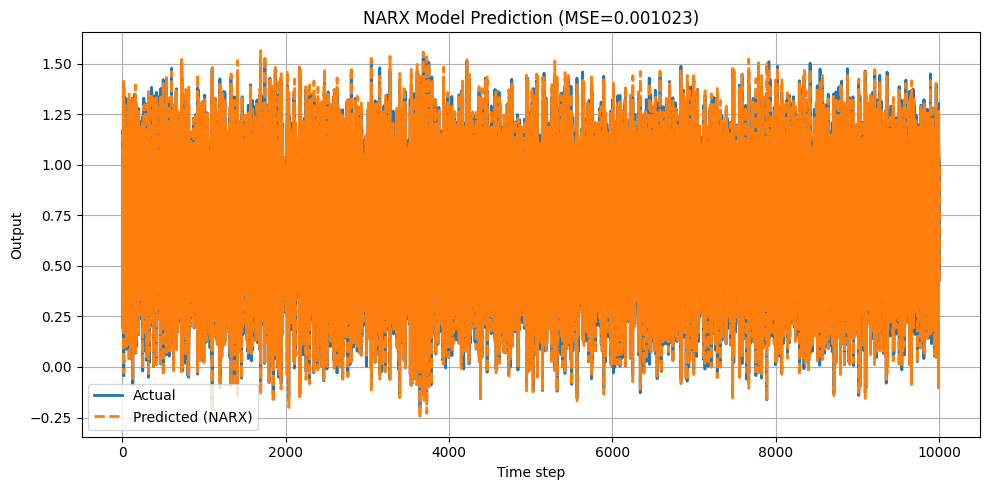

In [23]:
# --- prediction vs target plot ---
plt.figure(figsize=(10, 5))
plt.plot(T_test, label='Actual', linewidth=2)
plt.plot(predictions, label='Predicted (NARX)', linestyle='--', linewidth=2)
plt.title(f'NARX Model Prediction (MSE={mse_test:.6f})')
plt.xlabel('Time step')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
print(model.get_weights())

{'v': array([[ 3.80729012e-01,  9.46681800e-01,  7.11031743e-01,
         6.47182502e-01,  1.28265958e-01,  1.59395172e-01,
         1.10723669e-01,  8.68644669e-01,  6.16399434e-01,
         7.20543481e-01,  1.65835164e-02,  9.73305807e-01,
         8.51026639e-01,  2.16973773e-01,  1.60980382e-01,
         1.75096861e-01,  2.96140665e-01,  4.86766079e-01,
         4.35822671e-01,  2.83788017e-01,  6.03722638e-01,
         1.53584968e-01,  2.64028952e-01,  3.39810960e-01,
         4.55573926e-01,  8.09202493e-01,  9.64899507e-02,
         5.79857011e-01,  6.22386371e-01,  5.42494164e-02,
         6.27791434e-01,  1.99149597e-01,  9.35455250e-02,
         9.47174783e-01,  9.84597427e-01,  8.18996605e-01,
         3.05695502e-01,  1.34871282e-01,  6.86099101e-01,
         4.19857765e-01,  1.13216557e-01,  4.43671641e-01,
         6.86427960e-02,  9.27398360e-01,  1.80799951e-01,
         6.77760715e-01,  3.20323694e-01,  5.21757244e-01,
         5.48220850e-01,  1.86346150e-01,  9.34695

In [ ]:
# assuming: model, optimizer, loss_fn, X_train, T_train, X_val, T_val are ready
y_lags = 2  # how many previous outputs to include
n_epochs = 500
patience = 10
best_val_loss = float('inf')
patience_ctr = 0
train_losses, val_losses = [], []

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0.0

    for i in range(len(X_train)):
        # === feedback setup ===
        y_buffer = [torch.zeros((1, 1, 1), device=device) for _ in range(y_lags)]

        x_input = X_train[i].unsqueeze(0).to(device)  # shape (1, seq_len, 1)
        t_target = T_train[i].unsqueeze(0).to(device) # shape (1, seq_len, 1)

        # concatenate feedback (past outputs)
        y_concat = torch.cat(y_buffer, dim=2)
        x_aug = torch.cat([x_input, y_concat], dim=2)  # now input_size = 1 + y_lags

        # forward + backward
        y_pred = model(x_aug)
        loss = loss_fn(y_pred, t_target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update feedback buffer with current output
        y_buffer = [y_pred[:, -1:, :]] + y_buffer[:-1]

        epoch_loss += loss.item()

    # === validation ===
    model.eval()
    with torch.no_grad():
        y_buffer = [torch.zeros((1, 1, 1), device=device) for _ in range(y_lags)]
        y_preds, y_trues = [], []
        for i in range(len(X_val)):
            x_input = X_val[i].unsqueeze(0).to(device)
            t_target = T_val[i].unsqueeze(0).to(device)

            y_concat = torch.cat(y_buffer, dim=2)
            x_aug = torch.cat([x_input, y_concat], dim=2)
            y_pred = model(x_aug)
            y_buffer = [y_pred[:, -1:, :]] + y_buffer[:-1]
            y_preds.append(y_pred[:, -1:, :])
            y_trues.append(t_target[:, -1:, :])

        val_loss = loss_fn(torch.cat(y_preds, dim=0), torch.cat(y_trues, dim=0)).item()

    train_losses.append(epoch_loss / len(X_train))
    val_losses.append(val_loss)

    # === early stopping ===
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model_narx.pt")
        patience_ctr = 0
    else:
        patience_ctr += 1

    if patience_ctr >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: train MSE {epoch_loss / len(X_train):.6f}, val MSE {val_loss:.6f}")
